In [14]:
import pandas as pd
import numpy as np

def alpha(f1,f2):
    y = 1.64*(f1-f2)-2.82
    return y


def mJy_to_mag(F, F0):
    m = -2.5*np.log10(F*0.001/F0)
    return m


def e_mJy_to_mag(e_F, F):
    m = (2.5/np.log(10))*(e_F/F)
    return m

# c2d CLOUDS/CORES

In [66]:
c2d = pd.read_csv("../Data_and_Results/c2d_CLOUDS_HREL.csv")
# c2d = pd.read_csv("../Data_and_Results/c2d_CORES_HREL.csv")
# print(c2d.info())

c2d.head()

,region,c2d_id,ra,dec,alpha,object_type,j_flux_c,j_d_flux_c,h_flux_c,h_d_flux_c,...,ir2_flux_c,ir2_d_flux_c,ir3_flux_c,ir3_d_flux_c,ir4_flux_c,ir4_d_flux_c,mp1_flux_c,mp1_d_flux_c,mp2_flux_c,mp2_d_flux_c
0,PER,SSTc2d J032857.2+311419,52.238365,31.238644,-1.82,YSOc_star+dust(MP1),843.000000,19.400000,796.0,16.10,...,172.000000,8.88,108.000000,5.16,61.299999,6.200000,299.00,48.200001,0.0,0.0
1,SER,SSTc2d J182920.0+012102,277.333466,1.350421,-2.30,YSOc_star+dust(MP1),53.299999,1.420000,158.0,5.25,...,73.900002,3.68,61.500000,2.88,38.599998,1.990000,9.95,0.953000,NaN,NaN
2,LUP_III,SSTc2d J161118.7-385824,242.827881,-38.973213,-2.02,YSOc_star+dust(MP1),3070.000000,67.800003,6380.0,247.00,...,2530.000000,148.00,2390.000000,123.00,1600.000000,91.199997,518.00,49.700001,NaN,NaN
3,SER,SSTc2d J182920.0+002450,277.333405,0.413830,-2.10,YSOc_star+dust(MP1),64.800003,1.250000,167.0,4.78,...,96.000000,5.27,83.599998,4.28,56.799999,2.910000,16.00,1.500000,NaN,NaN
4,OPH,SSTc2d J162157.7-242943,245.490265,-24.495407,-2.37,YSOc_star+dust(MP1),897.000000,17.400000,773.0,28.50,...,194.000000,10.00,129.000000,6.38,76.900002,3.660000,27.00,2.500000,NaN,NaN


In [67]:
c2d_IRAC = c2d[["c2d_id","object_type","region","ir1_flux_c","ir1_d_flux_c","ir2_flux_c","ir2_d_flux_c","ir3_flux_c","ir3_d_flux_c","ir4_flux_c","ir4_d_flux_c"]]
c2d_IRAC = c2d_IRAC[~c2d_IRAC["ir1_d_flux_c"].isna() & ~c2d_IRAC["ir2_flux_c"].isna() & ~c2d_IRAC["ir3_flux_c"].isna() & ~c2d_IRAC["ir4_flux_c"].isna()]
neg_ind = c2d_IRAC[["ir1_flux_c","ir1_d_flux_c","ir2_flux_c","ir2_d_flux_c","ir3_flux_c","ir3_d_flux_c","ir4_flux_c","ir4_d_flux_c"]].index[(c2d_IRAC[\
    ["ir1_flux_c","ir1_d_flux_c","ir2_flux_c","ir2_d_flux_c","ir3_flux_c","ir3_d_flux_c","ir4_flux_c","ir4_d_flux_c"]].values<0).any(1)]
c2d_IRAC.drop(neg_ind)

# Load in magnitude data
# Access data by band instead of object
c2d_IRAC_fluxes = c2d_IRAC[["ir1_flux_c","ir1_d_flux_c","ir2_flux_c","ir2_d_flux_c","ir3_flux_c","ir3_d_flux_c","ir4_flux_c","ir4_d_flux_c"]].values.astype(float).transpose() 
band_names = ["ir1_flux_c","ir1_d_flux_c","ir2_flux_c","ir2_d_flux_c","ir3_flux_c","ir3_d_flux_c","ir4_flux_c","ir4_d_flux_c"]
# Convert magnitudes to flux
for i, F_0 in enumerate([277.500, 277.500, 179.500, 179.500, 116.600, 116.600, 63.100, 63.100]):
    if i%2==0:
        c2d_IRAC[band_names[i]] = mJy_to_mag(c2d_IRAC_fluxes[i],F_0) # Convert fluxes in a column to mags
    else:
        c2d_IRAC[band_names[i]] = e_mJy_to_mag(c2d_IRAC_fluxes[i],c2d_IRAC_fluxes[i-1]) # Convert errors in a column to mag
inf_ind_2 = c2d_IRAC[["ir1_flux_c","ir1_d_flux_c","ir2_flux_c","ir2_d_flux_c","ir3_flux_c","ir3_d_flux_c","ir4_flux_c","ir4_d_flux_c"]].index[np.isinf(c2d_IRAC[["ir1_flux_c","ir1_d_flux_c","ir2_flux_c","ir2_d_flux_c","ir3_flux_c","ir3_d_flux_c","ir4_flux_c","ir4_d_flux_c"]]).any(1)]
c2d_IRAC = c2d_IRAC.drop(inf_ind_2)

c2d_IRAC.head()

/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_5238/3074417221.py:10: RuntimeWarning: divide by zero encountered in log10
  m = -2.5*np.log10(F*0.001/F0)
/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_5238/3074417221.py:10: RuntimeWarning: invalid value encountered in log10
  m = -2.5*np.log10(F*0.001/F0)
/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_5238/3074417221.py:15: RuntimeWarning: invalid value encountered in true_divide
  m = (2.5/np.log(10))*(e_F/F)
/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_5238/3074417221.py:15: RuntimeWarning: divide by zero encountered in true_divide
  m = (2.5/np.log(10))*(e_F/F)


,c2d_id,object_type,region,ir1_flux_c,ir1_d_flux_c,ir2_flux_c,ir2_d_flux_c,ir3_flux_c,ir3_d_flux_c,ir4_flux_c,ir4_d_flux_c
0,SSTc2d J032857.2+311419,YSOc_star+dust(MP1),PER,7.600356,0.055360,7.546340,0.056054,7.583187,0.051874,7.531422,0.109813
1,SSTc2d J182920.0+012102,YSOc_star+dust(MP1),SER,8.357231,0.054976,8.463550,0.054066,8.194559,0.050844,8.033605,0.055974
2,SSTc2d J161118.7-385824,YSOc_star+dust(MP1),LUP_III,4.982535,0.099333,4.627360,0.063513,4.220752,0.055877,3.989773,0.061887
3,SSTc2d J182920.0+002450,YSOc_star+dust(MP1),SER,8.197275,0.065070,8.179483,0.059602,7.861231,0.055586,7.614203,0.055625
4,SSTc2d J162157.7-242943,YSOc_star+dust(MP1),OPH,7.440988,0.072629,7.415657,0.055966,7.390272,0.053698,7.285258,0.051675


In [68]:
neg_ind

Int64Index([  1094,   1221,   1222,   1247,   1344,   1370,   1582,   1583,
              1636,   1653,
            ...
            283752, 283756, 283760, 283772, 283816, 283820, 283838, 283851,
            283854, 283867],
           dtype='int64', length=10973)

In [69]:
pd.unique(c2d_IRAC["object_type"])

array(['YSOc_star+dust(MP1)', 'YSOc_star+dust(IR4)',
       'YSOc_star+dust(IR3)', 'YSOc_star+dust(IR2)',
       'YSOc_star+dust(IR1)', 'YSOc_red', 'YSOc_PAH-em', 'YSOc',
       'star+dust(MP1)', 'star+dust(IR4)', 'star+dust(IR3)',
       'star+dust(IR2)', 'star+dust(IR1)', 'star', 'Galc_star+dust(MP1)',
       'Galc_star+dust(IR4)', 'Galc_star+dust(IR3)',
       'Galc_star+dust(IR2)', 'Galc_star+dust(IR1)', 'Galc_red',
       'Galc_PAH-em', 'Galc'], dtype=object)

In [70]:
c2d_YSO_1 = pd.merge_ordered(c2d_IRAC[c2d_IRAC["object_type"]=='YSOc_star+dust(MP1)'],c2d_IRAC[c2d_IRAC["object_type"]=='YSOc_star+dust(IR4)'])
c2d_YSO_2 = pd.merge_ordered(c2d_IRAC[c2d_IRAC["object_type"]=='YSOc_star+dust(IR2)'],c2d_IRAC[c2d_IRAC["object_type"]=='YSOc_star+dust(IR3)'])
c2d_YSO_3 = pd.merge_ordered(c2d_IRAC[c2d_IRAC["object_type"]=='YSOc_star+dust(IR1)'],c2d_IRAC[c2d_IRAC["object_type"]=='YSOc_red'])
c2d_YSO_4 = pd.merge_ordered(c2d_IRAC[c2d_IRAC["object_type"]=='YSOc_PAH-em'],c2d_IRAC[c2d_IRAC["object_type"]=='YSOc'])
c2d_YSO_12 = pd.merge_ordered(c2d_YSO_1,c2d_YSO_2)
c2d_YSO_34 = pd.merge_ordered(c2d_YSO_3,c2d_YSO_4)
c2d_YSO = pd.merge_ordered(c2d_YSO_12,c2d_YSO_34)

c2d_YSO["Target"] = 0


c2d_EG_1 = pd.merge_ordered(c2d_IRAC[c2d_IRAC["object_type"]=='Galc_star+dust(MP1)'],c2d_IRAC[c2d_IRAC["object_type"]=='Galc_star+dust(IR4)'])
c2d_EG_2 = pd.merge_ordered(c2d_IRAC[c2d_IRAC["object_type"]=='Galc_star+dust(IR2)'],c2d_IRAC[c2d_IRAC["object_type"]=='Galc_star+dust(IR3)'])
c2d_EG_3 = pd.merge_ordered(c2d_IRAC[c2d_IRAC["object_type"]=='Galc_star+dust(IR1)'],c2d_IRAC[c2d_IRAC["object_type"]=='Galc_red'])
c2d_EG_4 = pd.merge_ordered(c2d_IRAC[c2d_IRAC["object_type"]=='Galc_PAH-em'],c2d_IRAC[c2d_IRAC["object_type"]=='Galc'])
c2d_EG_12 = pd.merge_ordered(c2d_EG_1,c2d_EG_2)
c2d_EG_34 = pd.merge_ordered(c2d_EG_3,c2d_EG_4)
c2d_EG = pd.merge_ordered(c2d_EG_12,c2d_EG_34)
c2d_EG["Target"] = 1


c2d_ST_1 = pd.merge_ordered(c2d_IRAC[c2d_IRAC["object_type"]=='star+dust(MP1)'],c2d_IRAC[c2d_IRAC["object_type"]=='star+dust(IR4)'])
c2d_ST_2 = pd.merge_ordered(c2d_IRAC[c2d_IRAC["object_type"]=='star+dust(IR2)'],c2d_IRAC[c2d_IRAC["object_type"]=='star+dust(IR3)'])
c2d_ST_3 = pd.merge_ordered(c2d_IRAC[c2d_IRAC["object_type"]=='Galc_star+dust(IR1)'],c2d_IRAC[c2d_IRAC["object_type"]=='star'])
c2d_ST_12 = pd.merge_ordered(c2d_ST_1,c2d_ST_2)
c2d_ST = pd.merge_ordered(c2d_ST_3,c2d_ST_12)
c2d_ST["Target"] = 2

c2d_IRAC_1 = pd.merge_ordered(c2d_YSO,c2d_EG)
c2d_IRAC_NEW = pd.merge_ordered(c2d_IRAC_1,c2d_ST)

c2d_IRAC_NEW.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 262277 entries, 0 to 262276
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   c2d_id        262277 non-null  object 
 1   object_type   262277 non-null  object 
 2   region        262277 non-null  object 
 3   ir1_flux_c    262241 non-null  float64
 4   ir1_d_flux_c  262277 non-null  float64
 5   ir2_flux_c    262231 non-null  float64
 6   ir2_d_flux_c  262277 non-null  float64
 7   ir3_flux_c    261382 non-null  float64
 8   ir3_d_flux_c  262277 non-null  float64
 9   ir4_flux_c    252219 non-null  float64
 10  ir4_d_flux_c  262277 non-null  float64
 11  Target        262277 non-null  int64  
dtypes: float64(8), int64(1), object(3)
memory usage: 26.0+ MB


In [71]:
print(f"YSO shape: {c2d_YSO.shape}")
print(f"EG shape: {c2d_EG.shape}")
print(f"Star shape: {c2d_ST.shape}")

YSO shape: (1082, 12)
EG shape: (2888, 12)
Star shape: (258307, 12)


In [72]:
# Calculate alphas and add to be consisitent with available bands ([4.5]-[8])
c2d_IRAC_NEW["alpha"] = alpha(c2d_IRAC_NEW["ir2_flux_c"],c2d_IRAC_NEW["ir4_flux_c"])

c2d_IRAC_NEW.head()

,c2d_id,object_type,region,ir1_flux_c,ir1_d_flux_c,ir2_flux_c,ir2_d_flux_c,ir3_flux_c,ir3_d_flux_c,ir4_flux_c,ir4_d_flux_c,Target,alpha
0,SSTc2d J032346.7+303939,star,PER,12.988224,0.055514,12.983417,0.058063,12.936510,0.075306,12.739697,0.096343,2,-2.420300
1,SSTc2d J032349.9+303959,star,PER,13.565574,0.054809,13.563511,0.056220,13.526501,0.097548,13.446064,0.139830,2,-2.627386
2,SSTc2d J032350.1+303815,star,PER,14.328639,0.057344,14.352117,0.061614,14.305766,0.148859,14.166226,0.294586,2,-2.515139
3,SSTc2d J032351.3+303902,star,PER,15.405574,0.065372,15.187719,0.076217,14.898721,0.229871,14.622945,0.400008,2,-1.893771
4,SSTc2d J032357.4+303525,star,PER,13.960312,0.056915,13.957229,0.056949,13.887038,0.129954,14.052631,0.199891,2,-2.976459


In [73]:
np.save("../Data_and_Results/c2d_Inputs_CLOUDS_Train.npy",c2d_IRAC_NEW[["ir1_flux_c","ir1_d_flux_c","ir2_flux_c","ir2_d_flux_c","ir3_flux_c","ir3_d_flux_c","ir4_flux_c","ir4_d_flux_c","alpha"]].values.astype(float))
np.save("../Data_and_Results/c2d_Targets_CLOUDS_Train.npy",c2d_IRAC_NEW[["Target"]].values.astype(int))

# np.save("../Data_and_Results/c2d_Inputs_CORES_Valid.npy",c2d_IRAC_NEW[["ir1_flux_c","ir1_d_flux_c","ir2_flux_c","ir2_d_flux_c","ir3_flux_c","ir3_d_flux_c","ir4_flux_c","ir4_d_flux_c","alpha"]].values.astype(float))
# np.save("../Data_and_Results/c2d_Targets_CORES_Valid.npy",c2d_IRAC_NEW[["Target"]].values.astype(int))

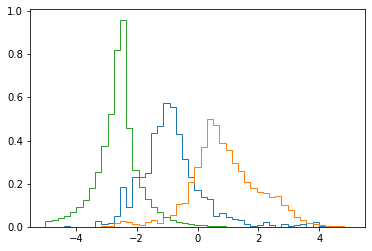

In [90]:
import matplotlib.pyplot as plt
bins= np.linspace(-5,5,20)

c2d_tar = c2d_IRAC_NEW[["Target"]].values.astype(int)
c2d_inp = c2d_IRAC_NEW[["ir1_flux_c","ir1_d_flux_c","ir2_flux_c","ir2_d_flux_c","ir3_flux_c","ir3_d_flux_c","ir4_flux_c","ir4_d_flux_c","alpha"]].values.astype(float)
EG = np.where(c2d_tar==1)[0]
alphasEG = c2d_inp[EG].transpose()[8]

YSO = np.where(c2d_tar==0)[0]
alphasYS = c2d_inp[YSO].transpose()[8]

ST = np.where(c2d_tar==2)[0]
alphasST = c2d_inp[ST].transpose()[8]

bins= np.linspace(-5,5,50)
plt.hist(alphasYS,bins,histtype='step',label='YSO',density=True)
plt.hist(alphasEG,bins,histtype='step',label='EG',density=True)
plt.hist(alphasST,bins,histtype='step',label='Stars',density=True)

plt.show()

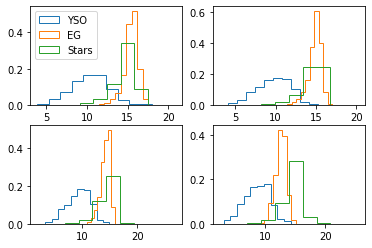

In [96]:
fig, axs = plt.subplots(2,2)
axs[0][0].hist(c2d_inp[YSO].transpose()[0],histtype='step',label='YSO',density=True)
axs[0][0].hist(c2d_inp[EG].transpose()[0],histtype='step',label='EG',density=True)
axs[0][0].hist(c2d_inp[ST].transpose()[0],histtype='step',label='Stars',density=True)
axs[0][0].legend()

axs[0][1].hist(c2d_inp[YSO].transpose()[2],histtype='step',label='YSO',density=True)
axs[0][1].hist(c2d_inp[EG].transpose()[2],histtype='step',label='EG',density=True)
axs[0][1].hist(c2d_inp[ST].transpose()[2],histtype='step',label='Stars',density=True)

axs[1][0].hist(c2d_inp[YSO].transpose()[4],histtype='step',label='YSO',density=True)
axs[1][0].hist(c2d_inp[EG].transpose()[4],histtype='step',label='EG',density=True)
axs[1][0].hist(c2d_inp[ST].transpose()[4],histtype='step',label='Stars',density=True)

axs[1][1].hist(c2d_inp[YSO].transpose()[6],histtype='step',label='YSO',density=True)
axs[1][1].hist(c2d_inp[EG].transpose()[6],histtype='step',label='EG',density=True)
axs[1][1].hist(c2d_inp[ST].transpose()[6],histtype='step',label='Stars',density=True)

plt.show()

# Rapson Data

In [77]:
df_Rap = pd.read_csv("../Data_and_Results/Rapson_YSO_EG_ST.tsv",sep=';',comment='#')
df_Rap = df_Rap[df_Rap["8mag"]!='     ']
df_Rap = df_Rap[df_Rap["5.8mag"]!='     '] 
df_Rap = df_Rap[df_Rap["4.5mag"]!='     ']
df_Rap = df_Rap[df_Rap["3.6mag"]!='     ']
df_Rap.info()

# pd.unique(df_Rap["4.5mag"])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8444 entries, 4 to 10448
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        8444 non-null   int64 
 1   RAJ2000   8444 non-null   object
 2   DEJ2000   8444 non-null   object
 3   3.6mag    8444 non-null   object
 4   e_3.6mag  8444 non-null   object
 5   4.5mag    8444 non-null   object
 6   e_4.5mag  8444 non-null   object
 7   5.8mag    8444 non-null   object
 8   e_5.8mag  8444 non-null   object
 9   8mag      8444 non-null   object
 10  e_8mag    8444 non-null   object
 11  24mag     8444 non-null   object
 12  e_24mag   8444 non-null   object
 13  Class     8444 non-null   object
dtypes: int64(1), object(13)
memory usage: 989.5+ KB


In [78]:
Rap_YSO_1 = pd.merge_ordered(df_Rap[df_Rap["Class"]=='0/I'],df_Rap[df_Rap["Class"]=='II'])
Rap_YSO = pd.merge_ordered(Rap_YSO_1,df_Rap[df_Rap["Class"]=='TD'])
Rap_YSO["Target"] = 0

Rap_EG_1 = pd.merge_ordered(df_Rap[df_Rap["Class"]=='AGN'],df_Rap[df_Rap["Class"]=='PAH'])
Rap_EG = pd.merge_ordered(Rap_EG_1,df_Rap[df_Rap["Class"]=='SHOCK'])
Rap_EG["Target"] = 1

Rap_ST = df_Rap[df_Rap["Class"]=="III/F"]
Rap_ST["Target"] = 2

Rap_NEW_1 = pd.merge_ordered(Rap_YSO,Rap_EG)
Rap_NEW = pd.merge_ordered(Rap_NEW_1, Rap_ST)

print(f"YSO shape: {Rap_YSO.shape}")
print(f"EG shape: {Rap_EG.shape}")
print(f"Stars shape: {Rap_ST.shape}")


Rap_NEW.info()

YSO shape: (553, 15)
EG shape: (373, 15)
Stars shape: (7518, 15)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8444 entries, 0 to 8443
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        8444 non-null   int64 
 1   RAJ2000   8444 non-null   object
 2   DEJ2000   8444 non-null   object
 3   3.6mag    8444 non-null   object
 4   e_3.6mag  8444 non-null   object
 5   4.5mag    8444 non-null   object
 6   e_4.5mag  8444 non-null   object
 7   5.8mag    8444 non-null   object
 8   e_5.8mag  8444 non-null   object
 9   8mag      8444 non-null   object
 10  e_8mag    8444 non-null   object
 11  24mag     8444 non-null   object
 12  e_24mag   8444 non-null   object
 13  Class     8444 non-null   object
 14  Target    8444 non-null   int64 
dtypes: int64(2), object(13)
memory usage: 1.0+ MB


/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_5238/2374731623.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Rap_ST["Target"] = 2


In [79]:
# Calculate alphas and add to be consisitent with available bands ([4.5]-[8])
Rap_NEW["alpha"] = alpha(Rap_NEW["4.5mag"].values.astype(float),Rap_NEW["8mag"].values.astype(float))

Rap_NEW.head()

,ID,RAJ2000,DEJ2000,3.6mag,e_3.6mag,4.5mag,e_4.5mag,5.8mag,e_5.8mag,8mag,e_8mag,24mag,e_24mag,Class,Target,alpha
0,34,06 43 10.32,+08 45 11.33,10.32,0.003,10.17,0.003,10.07,0.005,10.03,0.008,,,III/F,2,-2.5904
1,45,06 42 42.63,+08 45 20.25,11.62,0.003,11.60,0.004,11.55,0.016,11.56,0.035,,,III/F,2,-2.7544
2,54,06 43 02.63,+08 45 23.95,13.38,0.007,13.28,0.011,13.27,0.050,13.78,0.155,,,III/F,2,-3.6400
3,65,06 43 01.89,+08 45 32.18,12.52,0.005,12.52,0.006,12.40,0.030,12.41,0.053,,,III/F,2,-2.6396
4,84,06 42 53.88,+08 45 38.50,13.71,0.009,13.66,0.013,13.60,0.069,13.67,0.148,,,III/F,2,-2.8364


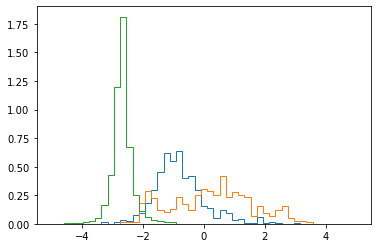

In [89]:
Rap_tar = Rap_NEW[["Target"]].values.astype(int)
Rap_inp = Rap_NEW[["3.6mag","e_3.6mag","4.5mag","e_4.5mag","5.8mag","e_5.8mag","8mag","e_8mag","alpha"]].values.astype(float)
EG = np.where(Rap_tar==1)[0]
alphasEG = Rap_inp[EG].transpose()[8]

YSO = np.where(Rap_tar==0)[0]
alphasYS = Rap_inp[YSO].transpose()[8]

ST = np.where(Rap_tar==2)[0]
alphasST = Rap_inp[ST].transpose()[8]

bins= np.linspace(-5,5,50)
plt.hist(alphasYS,bins,histtype='step',label='YSO',density=True)
plt.hist(alphasEG,bins,histtype='step',label='EG',density=True)
plt.hist(alphasST,bins,histtype='step',label='Stars',density=True)

plt.show()

In [39]:
np.save("../Data_and_Results/Rap_Inputs_Test.npy",Rap_NEW[["3.6mag","e_3.6mag","4.5mag","e_4.5mag","5.8mag","e_5.8mag","8mag","e_8mag","alpha"]].values.astype(float))
np.save("../Data_and_Results/Rap_Targets_Test.npy",Rap_NEW[["Target"]].values.astype(int))

# Data from CM21


If we follow the values CM21 used for each class, we should be using:
* Training
    * 1472 YSOs (331 CI and 1141 CII)
    * 857 EG (231 Gals, 529 AGN, 27 PAHs 70 Shocks)
    * 1257 Stars
* Validation
    * 613 YSOs (82 CI and 531 CII)
    * 405 EG (104 Gals, 278 AGNs, 6 PAHs, 17 Shocks)
    * 4359 Stars

We will use the above input and compare to using 1000 of each class. There are a total of:
* 3073 YSOs
* 2034 EG
* 21 796 Stars


# SPICY YSO Classification

In [5]:
df_SPICY = pd.read_csv("../Data_and_Results/SPICY_YSO_Subclasses.csv",comment='#')

df_SPICY.head()

,SPICY,RAdeg DEdeg,GLON GLAT,p1,p2,p3,class,Si,PAH,alpha,...,ag.1,ag.2,ag.3,2MASS,UKIDSS,VIRAC,GaiaDR2,MIPS,WISEA,ZTFDR3
0,1,125.664811 -37.551349,255.975183 -0.253369,0.710000,,,ClassII,0,0,-1.51695368300395E+00,...,2,2,2,08223956-3733048,,,5541983493883598976,,J082239.55-373304.5,NaN
1,2,125.795513 -37.585000,256.062070 -0.187675,0.690000,,,ClassII,0,0,-6.43206342197073E-01,...,2,2,2,08231092-3735060,,,5541980848188474496,,J082310.90-373505.9,NaN
2,3,125.860244 -37.577463,256.085297 -0.141319,0.870000,,,FS,0,0,-2.14090416881411E-03,...,2,2,2,08232646-3734388,,,5541969475116705664,,J082326.45-373438.8,NaN
3,4,125.946863 -37.770809,256.282985 -0.196119,0.530000,,,ClassI,0,0,3.37295842881326E-01,...,4,2,4,,,,,,J082347.25-374615.0,NaN
4,5,126.003155 -37.126075,255.780917 0.210831,0.540000,,,FS,0,0,-2.78597489454348E-01,...,2,2,2,08240071-3707341,,,5542020537982099840,,J082400.75-370733.7,NaN


In [6]:
df_SPICY_IRAC = df_SPICY[[" SPICY","3.6mag","e_3.6mag","4.5mag","e_4.5mag","5.8mag","e_5.8mag","8.0mag","e_8.0mag","class    "]]
df_SPICY_IRAC = df_SPICY_IRAC[df_SPICY_IRAC["8.0mag"]!='      ']
df_SPICY_IRAC = df_SPICY_IRAC[df_SPICY_IRAC["5.8mag"]!='      ']

df_SPICY_IRAC.head()

,SPICY,3.6mag,e_3.6mag,4.5mag,e_4.5mag,5.8mag,e_5.8mag,8.0mag,e_8.0mag,class
0,1,13.158,0.063,12.800,0.104,12.470,0.153,12.009,0.083,ClassII
1,2,13.180,0.059,12.727,0.097,12.241,0.120,11.404,0.059,ClassII
2,3,11.703,0.052,11.197,0.061,10.674,0.059,9.576,0.034,FS
3,4,14.271,0.096,13.398,0.084,12.462,0.142,11.478,0.045,ClassI
4,5,13.198,0.065,12.393,0.084,11.726,0.077,10.848,0.048,FS


In [11]:
df_SPICY_CI = df_SPICY_IRAC[df_SPICY_IRAC["class    "]=="ClassI   "]
df_SPICY_CI["Target"] = 0

df_SPICY_CFS = df_SPICY_IRAC[df_SPICY_IRAC["class    "]=="FS       "]
df_SPICY_CFS["Target"] = 1

df_SPICY_CII = df_SPICY_IRAC[df_SPICY_IRAC["class    "]=="ClassII  "]
df_SPICY_CII["Target"] = 2

df_SPICY_CIII = df_SPICY_IRAC[df_SPICY_IRAC["class    "]=="ClassIII "]
df_SPICY_CIII["Target"] = 3

df_YSO_NEW_1 = pd.merge_ordered(df_SPICY_CI,df_SPICY_CII)
df_YSO_NEW_2 = pd.merge_ordered(df_SPICY_CFS,df_SPICY_CIII)
df_YSO_NEW = pd.merge_ordered(df_YSO_NEW_1,df_YSO_NEW_2)

df_YSO_NEW['alphas'] = alpha(df_YSO_NEW["4.5mag"].values.astype(float),df_YSO_NEW["8.0mag"].values.astype(float))

df_YSO_NEW.head()

/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_9120/443959090.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_SPICY_CI["Target"] = 0
/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_9120/443959090.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_SPICY_CFS["Target"] = 1
/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_9120/443959090.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

,SPICY,3.6mag,e_3.6mag,4.5mag,e_4.5mag,5.8mag,e_5.8mag,8.0mag,e_8.0mag,class,Target,alphas
0,1,13.158,0.063,12.800,0.104,12.470,0.153,12.009,0.083,ClassII,2,-1.52276
1,2,13.180,0.059,12.727,0.097,12.241,0.120,11.404,0.059,ClassII,2,-0.65028
2,3,11.703,0.052,11.197,0.061,10.674,0.059,9.576,0.034,FS,1,-0.16156
3,4,14.271,0.096,13.398,0.084,12.462,0.142,11.478,0.045,ClassI,0,0.32880
4,5,13.198,0.065,12.393,0.084,11.726,0.077,10.848,0.048,FS,1,-0.28620


In [12]:
Inputs = df_YSO_NEW[["3.6mag","e_3.6mag","4.5mag","e_4.5mag","5.8mag","e_5.8mag","8.0mag","e_8.0mag","alphas"]].values.astype(float)
Targets = df_YSO_NEW[["Target"]].values.astype(float)


np.save("../Data_and_Results/Inputs_YSO_Train.npy",Inputs)
np.save("../Data_and_Results/Targets_YSO_Train.npy",Targets)

In [10]:
print(df_SPICY_CI.shape)
print(df_SPICY_CII.shape)
print(df_SPICY_CFS.shape)
print(df_SPICY_CIII.shape)

(15596, 11)
(59561, 11)
(23563, 11)
(5333, 11)
